<a href="https://colab.research.google.com/github/sudarshan-koirala/youtube-stuffs/blob/main/llamaindex/llamaindex_advanced_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced RAG with LlamaParse and Reranker

This notebook shows you how to use LlamaParse with our advanced markdown ingestion and recursive retrieval algorithms to model tables/text within a document hierarchically. This lets you ask questions over both tables and text.

Note for this example, we are using the `llama_index >=0.10.4` version

In [1]:
%%capture
!pip install llama-index
!pip install llama-index-core
!pip install llama-index-embeddings-openai
!pip install llama-index-postprocessor-flag-embedding-reranker
!pip install git+https://github.com/FlagOpen/FlagEmbedding.git
!pip install llama-parse
!pip install llama-index-embeddings-fastembed
!pip install fastembed
!pip install llama-index-llms-groq

In [2]:
!wget 'https://huggingface.co/silaseic/llamaindex_demo/resolve/main/uber_10q_march_2022.pdf?download=true' -O './uber_10q_march_2022.pdf'

--2024-03-31 18:03:48--  https://huggingface.co/silaseic/llamaindex_demo/resolve/main/uber_10q_march_2022.pdf?download=true
Resolving huggingface.co (huggingface.co)... 18.238.49.70, 18.238.49.112, 18.238.49.10, ...
Connecting to huggingface.co (huggingface.co)|18.238.49.70|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/db/82/db822043772ccb03c50d147d5942e00187b2c9684beaf6b475f70ff50e2e4b9f/e03fd66bebeef51aa4708a0e5506309734f4676dde85fb5f17f571c0d3f4d4bc?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27uber_10q_march_2022.pdf%3B+filename%3D%22uber_10q_march_2022.pdf%22%3B&response-content-type=application%2Fpdf&Expires=1712167428&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxMjE2NzQyOH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zL2RiLzgyL2RiODIyMDQzNzcyY2NiMDNjNTBkMTQ3ZDU5NDJlMDAxODdiMmM5Njg0YmVhZjZiNDc1ZjcwZmY1MGUyZTRiOWYvZ

In [3]:
# llama-parse is async-first, running the async code in a notebook requires the use of nest_asyncio
import nest_asyncio
nest_asyncio.apply()

# API access to llama-cloud
#LLAMA_CLOUD_API_KEY = "llx-*****"

# Using OpenAI API for embeddings/llms
#GROQ_API_KEY = "gsk_*****"

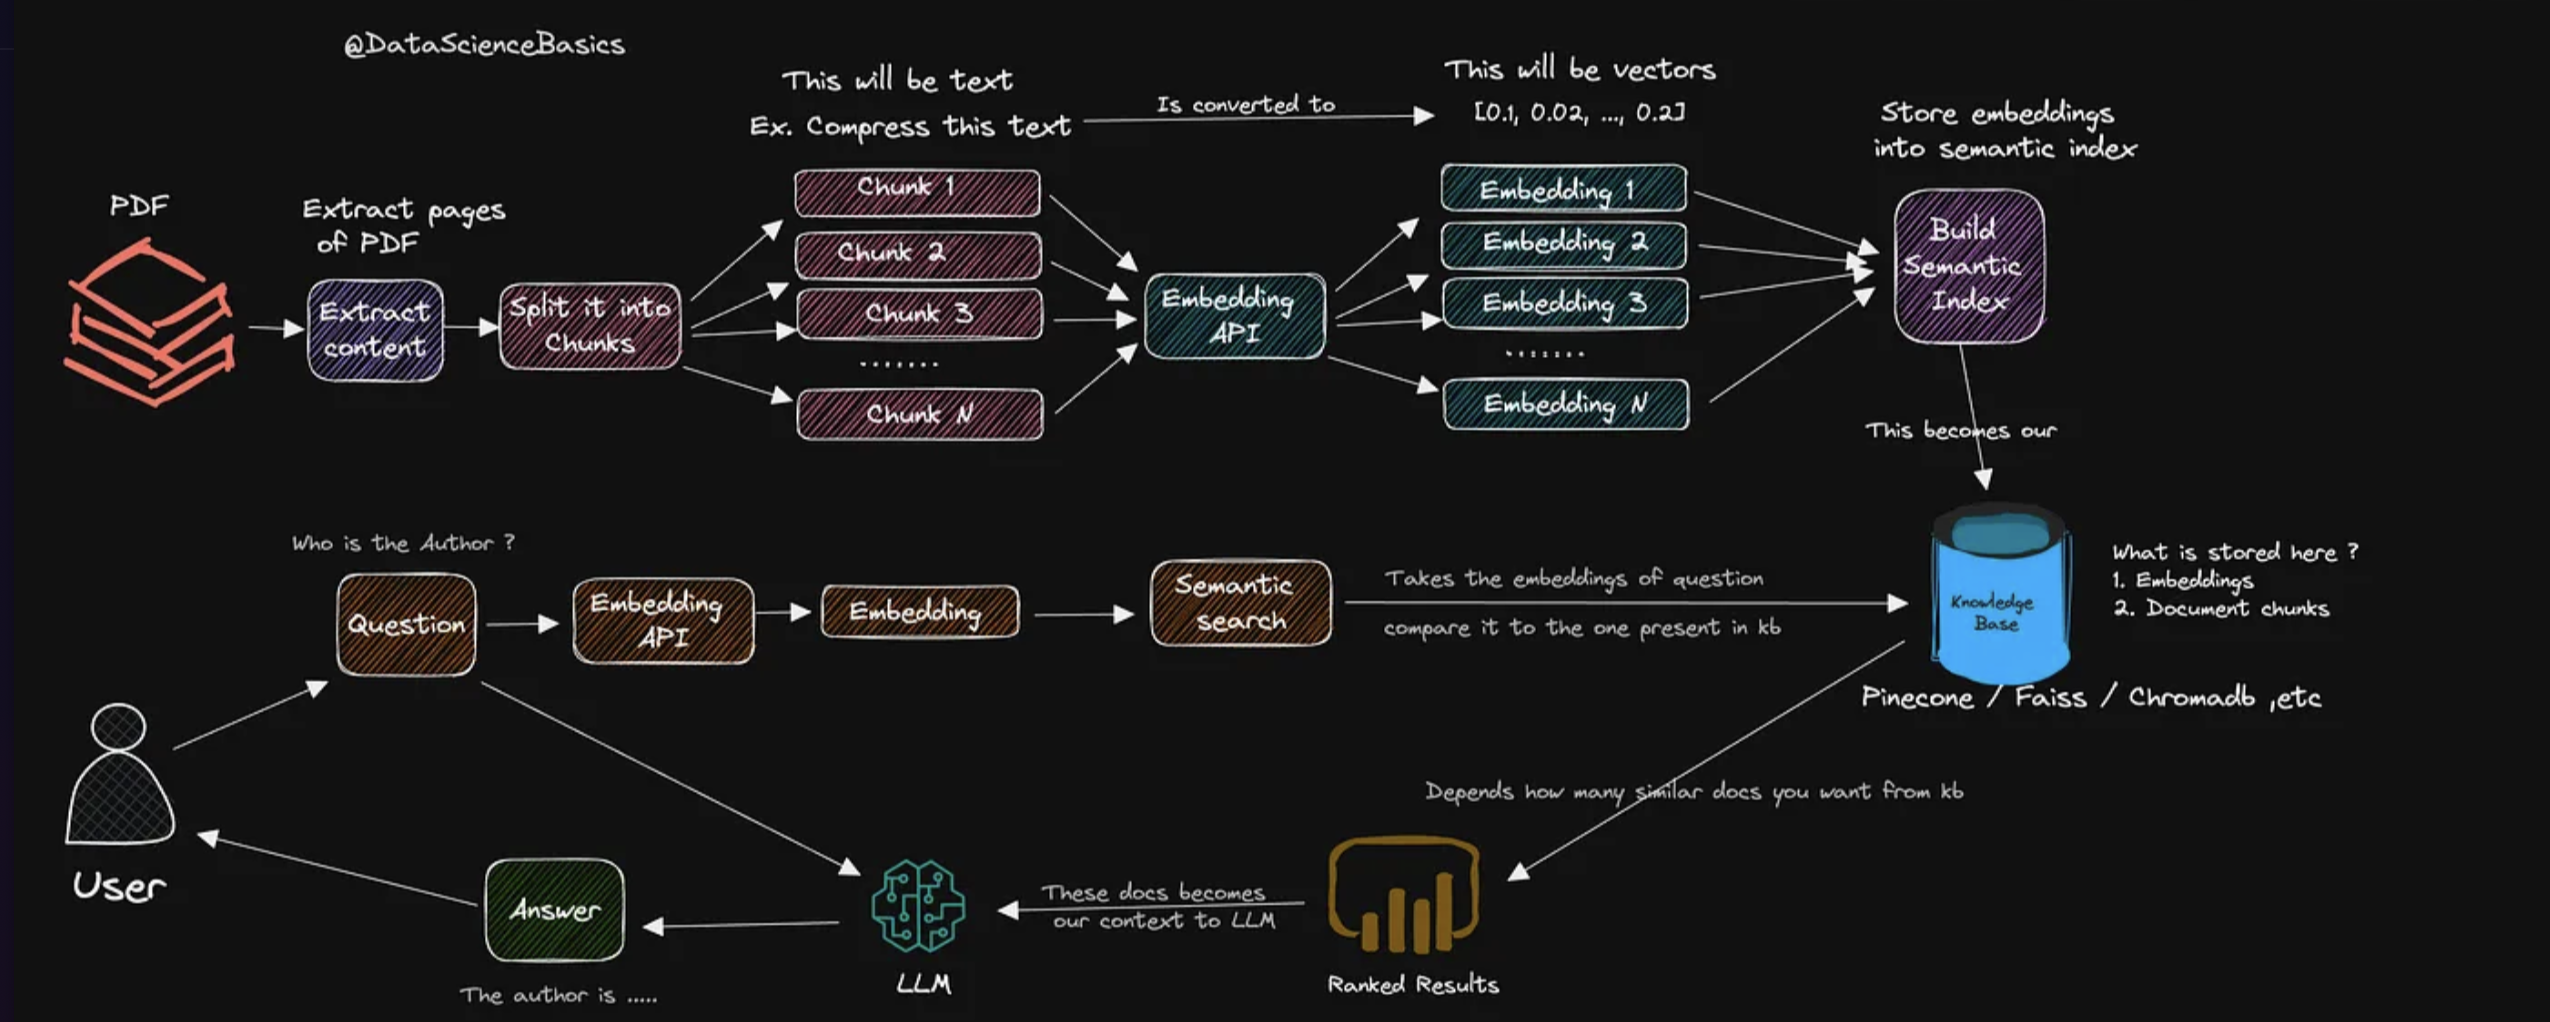

## Using brand new `LlamaParse` PDF reader for PDF Parsing

we also compare two different retrieval/query engine strategies:
1. Using raw Markdown text as nodes for building index and apply simple query engine for generating the results;
2. Using `MarkdownElementNodeParser` for parsing the `LlamaParse` output Markdown results and building recursive retriever query engine for generation.

In [5]:
from llama_parse import LlamaParse
from google.colab import userdata
LLAMA_CLOUD_API_KEY = userdata.get('LLAMA_CLOUD_API_KEY')

import pickle
import os
# Define a function to load parsed data if available, or parse if not
def load_or_parse_data():
    data_file = "./parsed_data.pkl"

    if os.path.exists(data_file):
        # Load the parsed data from the file
        with open(data_file, "rb") as f:
            parsed_data = pickle.load(f)
    else:
        # Perform the parsing step and store the result in llama_parse_documents
        parsingInstructionUber10k = """The provided document is a quarterly report filed by Uber Technologies,
        Inc. with the Securities and Exchange Commission (SEC).
        This form provides detailed financial information about the company's performance for a specific quarter.
        It includes unaudited financial statements, management discussion and analysis, and other relevant disclosures required by the SEC.
        It contains many tables.
        Try to be precise while answering the questions"""
        parser = LlamaParse(api_key=LLAMA_CLOUD_API_KEY, result_type="markdown", parsing_instruction=parsingInstructionUber10k)
        llama_parse_documents = parser.load_data("/content/uber_10q_march_2022.pdf")


        # Save the parsed data to a file
        with open(data_file, "wb") as f:
            pickle.dump(llama_parse_documents, f)

        # Set the parsed data to the variable
        parsed_data = llama_parse_documents

    return parsed_data

documents =  load_or_parse_data()

#documents = LlamaParse(api_key=LLAMA_CLOUD_API_KEY, result_type="markdown").load_data('./uber_10q_march_2022.pdf')

Started parsing the file under job_id d7573c3d-4501-4f6b-aebc-6682042ee862


In [6]:
print(documents[0].text[:1000] + '...')

# Uber Technologies, Inc. - Quarterly Report

# Uber Technologies, Inc. - Quarterly Report

Form 10-Q

Quarterly Report Pursuant to Section 13 or 15(d) of the Securities Exchange Act of 1934

For the quarterly period ended March 31, 2022

Commission File Number: 001-38902

Uber Technologies, Inc.

Address: 1515 3rd Street, San Francisco, California 94158

Telephone: (415) 612-8582

## Securities Registered

|Title of each class|Trading Symbol(s)|Name of each exchange on which registered|
|---|---|---|
|Common Stock, par value $0.00001 per share|UBER|New York Stock Exchange|

## Filing Information

Filed all reports required in the past 12 months: Yes

Submitted Interactive Data File: Yes

Large accelerated filer: Yes

Accelerated filer: No

Non-accelerated filer: No

Smaller reporting company: No

Emerging growth company: No

## Additional Information

Shell company: No

Number of shares outstanding (as of May 2, 2022): 1,963,660,253
---
# Uber Technologies, Inc. Quarterly Report

# UB

Grab the API keys
- [Groq API key](https://console.groq.com/keys)
- [OpenAI API key](https://platform.openai.com/api-keys)
- [LlamaCloud API key](https://cloud.llamaindex.ai/api-key)

In [ ]:
from llama_index.core import VectorStoreIndex
from llama_index.llms.groq import Groq
from llama_index.embeddings.fastembed import FastEmbedEmbedding
from llama_index.core import Settings
GROQ_API_KEY = userdata.get('GROQ_API_KEY')

# by default llamaindex uses OpenAI models
embed_model = FastEmbedEmbedding(model_name="BAAI/bge-base-en-v1.5")

llm = Groq(model="mixtral-8x7b-32768", api_key= GROQ_API_KEY)

Settings.llm = llm
Settings.embed_model = embed_model


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
from llama_index.core.node_parser import MarkdownElementNodeParser

node_parser = MarkdownElementNodeParser(llm = Groq(model="mixtral-8x7b-32768", api_key= GROQ_API_KEY), num_workers=8)

In [ ]:
nodes = node_parser.get_nodes_from_documents(documents)

78it [00:00, 21924.39it/s]
  0%|          | 0/78 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/llama_index/core/program/utils.py:58: UserWarning: Failed to use `OpenAIPydanticProgram`. Please ensure that is installed by running `pip install llama-index-program-openai`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/llama_index/core/program/utils.py:58: UserWarning: Failed to use `OpenAIPydanticProgram`. Please ensure that is installed by running `pip install llama-index-program-openai`.
  warnings.warn(
columns
  field required (type=value_error.missing)
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/llama_index/core/response_synthesizers/refine.py", line 477, in _agive_response_single
    structured_response = await program.acall(
  File "/usr/local/lib/python3.10/dist-packages/llama_index/core/response_synthesizers/refine.py", line 92, in acall
    answer = await self._llm.astructured_predict(
  File "/usr/local/lib/python3.10/d

ValueError: Could not extract json string from output: {
  "summary": "The table presents financial information related to net income, net loss, and net loss per share attributable to common stockholders for two time periods, potentially 2021 and 2

In [ ]:
#OPENAI_API_KEY = "sk-****"

Tried Groq's model but timeout issue, json string extraction problem persists, switched to OpenAI model.

In [ ]:
from llama_index.core.node_parser import MarkdownElementNodeParser

from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core import VectorStoreIndex
from llama_index.core import Settings
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')


embed_model=OpenAIEmbedding(model="text-embedding-3-small", api_key=OPENAI_API_KEY)
llm = OpenAI(model="gpt-3.5-turbo-0125", api_key=OPENAI_API_KEY)

Settings.embed_model = embed_model
Settings.llm = llm

node_parser = MarkdownElementNodeParser(llm = llm, num_workers=8)

In [7]:
#llm

In [ ]:
nodes = node_parser.get_nodes_from_documents(documents, progress =True)

78it [00:00, 15905.28it/s]
  1%|▏         | 1/78 [00:00<01:03,  1.22it/s]WARNING:llama_index.core.response_synthesizers.refine:Validation error on structured response: 1 validation error for TableOutput
columns
  field required (type=value_error.missing)
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/llama_index/core/response_synthesizers/refine.py", line 477, in _agive_response_single
    structured_response = await program.acall(
  File "/usr/local/lib/python3.10/dist-packages/llama_index/core/response_synthesizers/refine.py", line 92, in acall
    answer = await self._llm.astructured_predict(
  File "/usr/local/lib/python3.10/dist-packages/llama_index/core/instrumentation/dispatcher.py", line 162, in async_wrapper
    self.span_drop(id_=id_, bound_args=bound_args, instance=instance, err=e)
  File "/usr/local/lib/python3.10/dist-packages/llama_index/core/instrumentation/dispatcher.py", line 98, in span_drop
    h.span_drop(
  File "/usr/local/lib/p

In [ ]:
base_nodes, objects = node_parser.get_nodes_and_objects(nodes)

In [ ]:
recursive_index = VectorStoreIndex(nodes=base_nodes+objects)
raw_index = VectorStoreIndex.from_documents(documents)

In [ ]:
from llama_index.postprocessor.flag_embedding_reranker import FlagEmbeddingReranker

reranker = FlagEmbeddingReranker(
    top_n=5,
    model="BAAI/bge-reranker-large",
)

recursive_query_engine = recursive_index.as_query_engine(
    similarity_top_k=15,
    node_postprocessors=[reranker],
    verbose=True
)

raw_query_engine = raw_index.as_query_engine(similarity_top_k=15, node_postprocessors=[reranker])

 91%|█████████ | 71/78 [22:56<02:15, 19.38s/it]


tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

In [ ]:
print(len(nodes))

299


## Using `new LlamaParse` as pdf data parsing methods and retrieve tables with two different methods
we compare base query engine vs recursive query engine with tables

### Table Query Task: Queries for Table Question Answering

In [ ]:
query = "how is the Cash paid for Income taxes, net of refunds from Supplemental disclosures of cash flow information?"

response_1 = raw_query_engine.query(query)
print("\n***********New LlamaParse+ Basic Query Engine***********")
print(response_1)

response_2 = recursive_query_engine.query(query)
print("\n***********New LlamaParse+ Recursive Retriever Query Engine***********")
print(response_2)



***********New LlamaParse+ Basic Query Engine***********
$41
Retrieval entering id_30d6c920-feda-46c7-89fc-096279999005_40_table: TextNode
Retrieving from object TextNode with query how is the Cash paid for Income taxes, net of refunds from Supplemental disclosures of cash flow information?
Retrieval entering id_30d6c920-feda-46c7-89fc-096279999005_326_table: TextNode
Retrieving from object TextNode with query how is the Cash paid for Income taxes, net of refunds from Supplemental disclosures of cash flow information?
Retrieval entering id_30d6c920-feda-46c7-89fc-096279999005_330_table: TextNode
Retrieving from object TextNode with query how is the Cash paid for Income taxes, net of refunds from Supplemental disclosures of cash flow information?
Retrieval entering id_30d6c920-feda-46c7-89fc-096279999005_38_table: TextNode
Retrieving from object TextNode with query how is the Cash paid for Income taxes, net of refunds from Supplemental disclosures of cash flow information?
Retrieval en

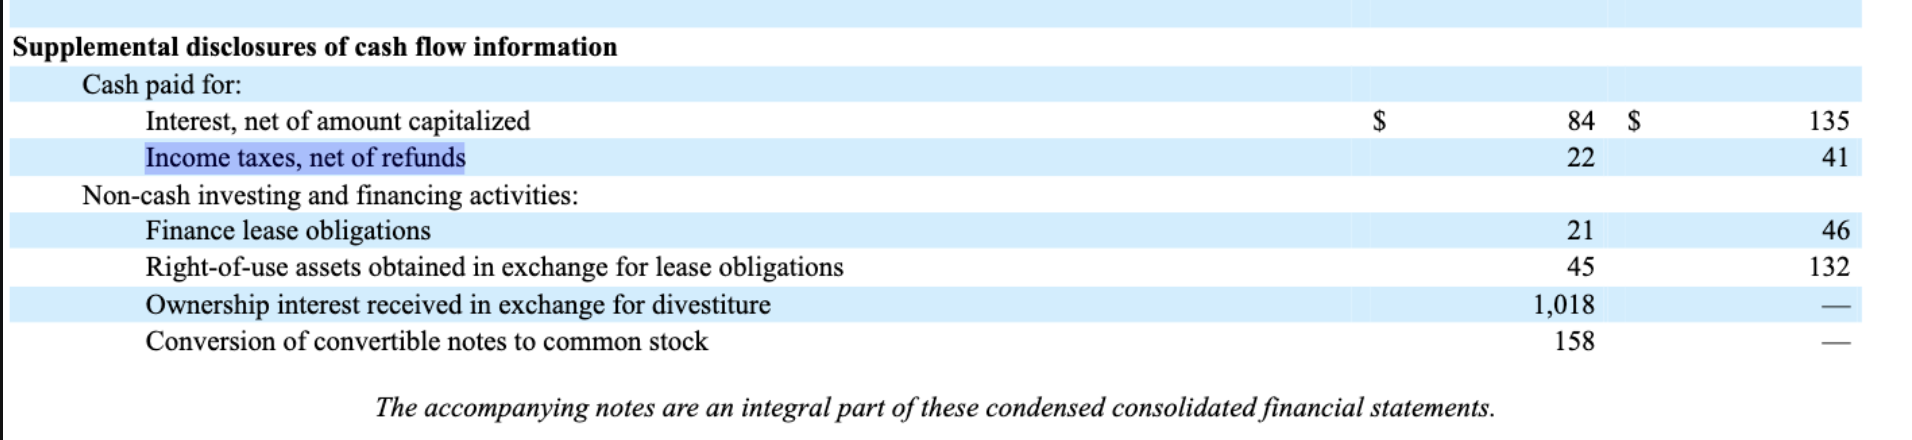

In [ ]:
query = "what is the change of free cash flow and what is the rate from the financial and operational highlights?"

response_1 = raw_query_engine.query(query)
print("\n***********New LlamaParse+ Basic Query Engine***********")
print(response_1)

response_2 = recursive_query_engine.query(query)
print("\n***********New LlamaParse+ Recursive Retriever Query Engine***********")
print(response_2)


***********New LlamaParse+ Basic Query Engine***********
The change in free cash flow from the financial and operational highlights is a decrease from $(682) million in 2021 to $(47) million in 2022. This represents a significant improvement in free cash flow performance from one period to the next.
Retrieval entering id_b656577b-91de-47ca-981e-8b1d63e20c20_320_table: TextNode
Retrieving from object TextNode with query what is the change of free cash flow and what is the rate from the financial and operational highlights?
Retrieval entering id_b656577b-91de-47ca-981e-8b1d63e20c20_38_table: TextNode
Retrieving from object TextNode with query what is the change of free cash flow and what is the rate from the financial and operational highlights?
Retrieval entering id_b656577b-91de-47ca-981e-8b1d63e20c20_44_table: TextNode
Retrieving from object TextNode with query what is the change of free cash flow and what is the rate from the financial and operational highlights?
Retrieval entering 

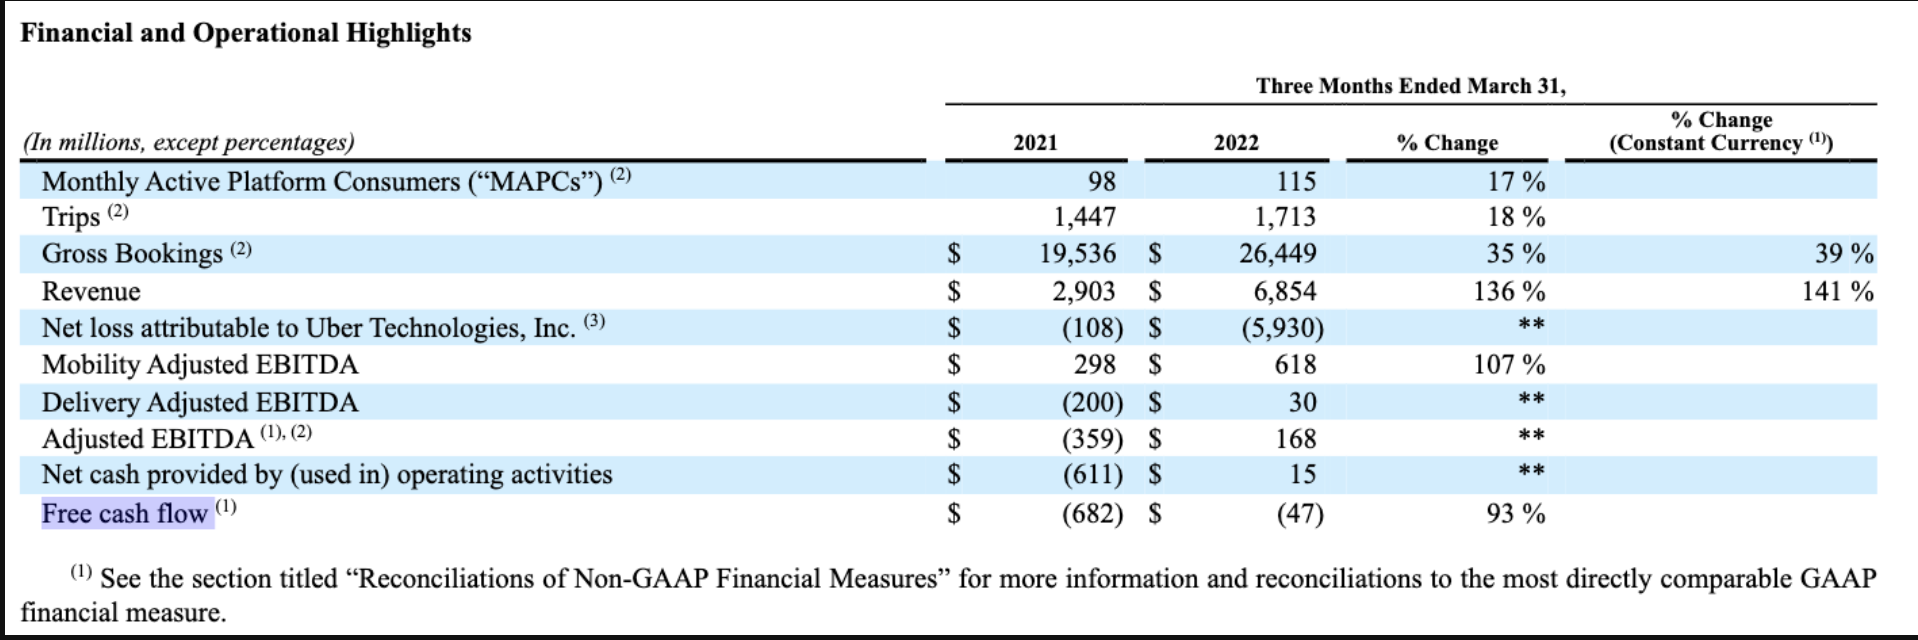

In [ ]:
query = "what is the net loss value attributable to Uber compared to last year?"

response_1 = raw_query_engine.query(query)
print("\n***********New LlamaParse+ Basic Query Engine***********")
print(response_1)

response_2 = recursive_query_engine.query(query)
print("\n***********New LlamaParse+ Recursive Retriever Query Engine***********")
print(response_2)


***********New LlamaParse+ Basic Query Engine***********
The net loss value attributable to Uber for the current period is $5.9 billion, which is an increase compared to the net loss of $108 million in the same period last year.
Retrieval entering id_b656577b-91de-47ca-981e-8b1d63e20c20_22_table: TextNode
Retrieving from object TextNode with query what is the net loss value attributable to Uber compared to last year?
Retrieval entering id_b656577b-91de-47ca-981e-8b1d63e20c20_316_table: TextNode
Retrieving from object TextNode with query what is the net loss value attributable to Uber compared to last year?
Retrieval entering id_b656577b-91de-47ca-981e-8b1d63e20c20_230_table: TextNode
Retrieving from object TextNode with query what is the net loss value attributable to Uber compared to last year?
Retrieval entering id_b656577b-91de-47ca-981e-8b1d63e20c20_26_table: TextNode
Retrieving from object TextNode with query what is the net loss value attributable to Uber compared to last year?


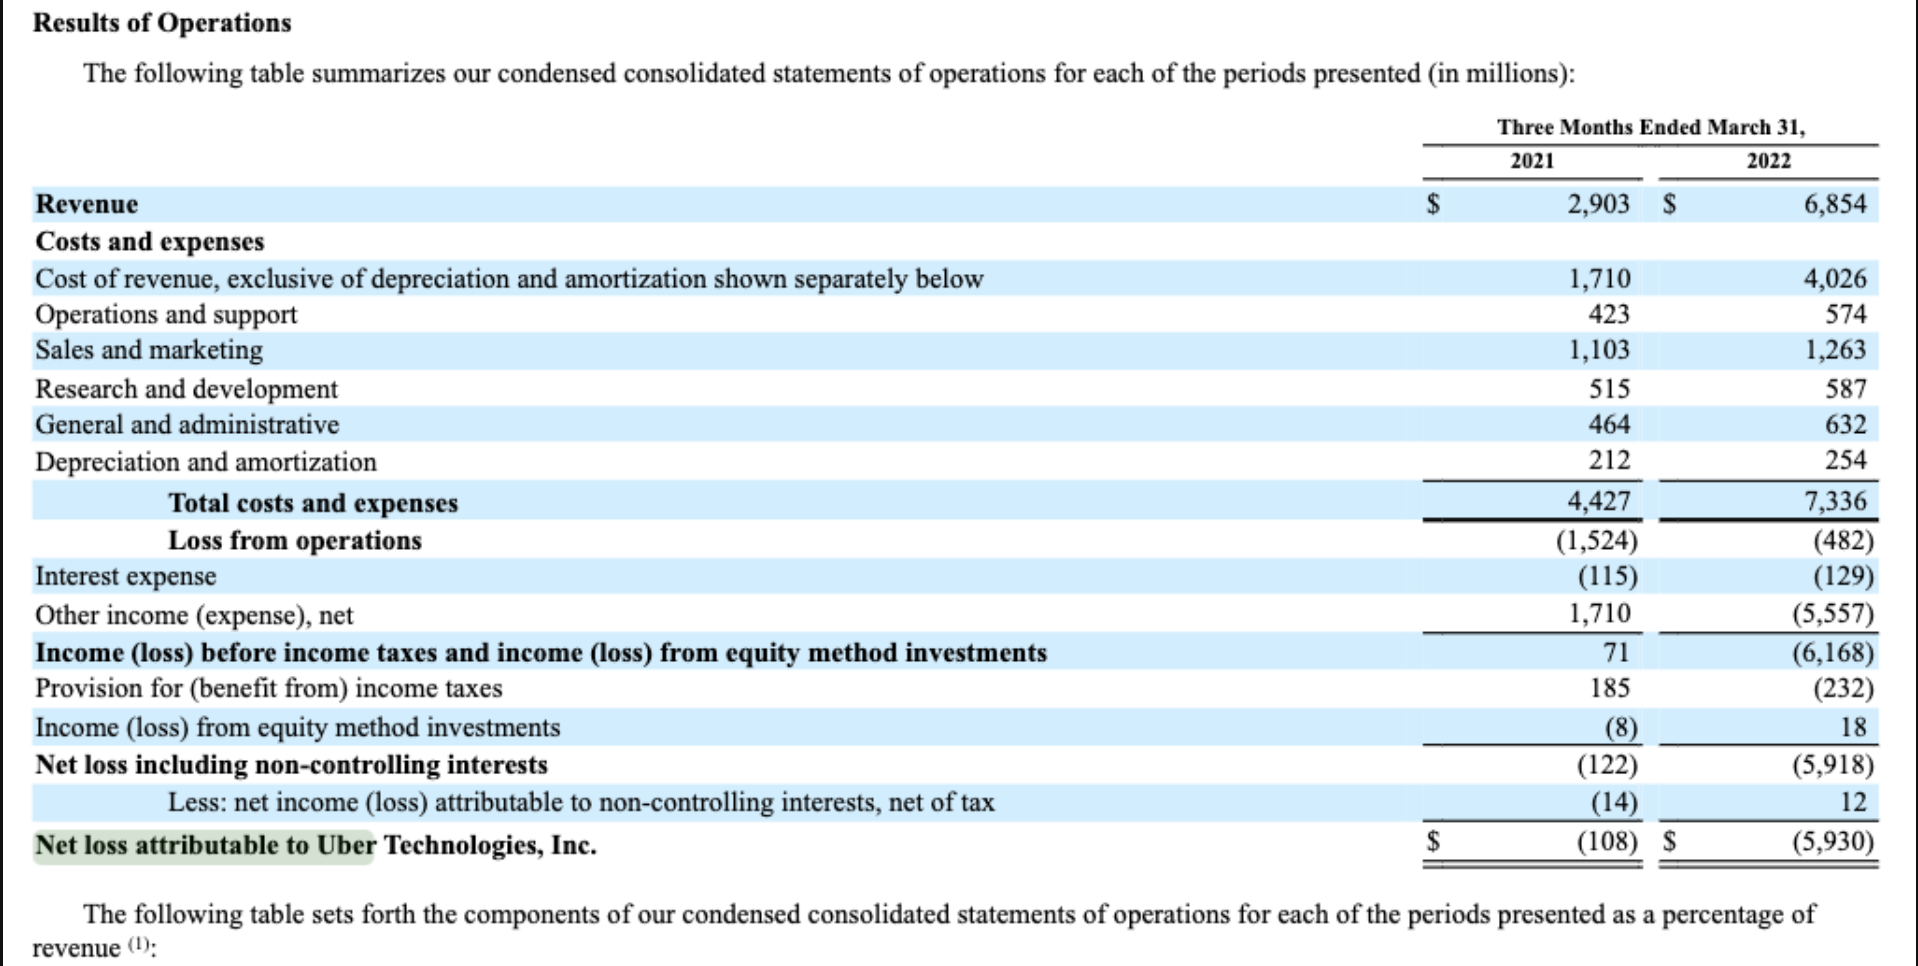

In [ ]:
query = "What were cash flows like from investing activities?"

response_1 = raw_query_engine.query(query)
print("\n***********New LlamaParse+ Basic Query Engine***********")
print(response_1)

response_2 = recursive_query_engine.query(query)
print("\n***********New LlamaParse+ Recursive Retriever Query Engine***********")
print(response_2)


***********New LlamaParse+ Basic Query Engine***********
Cash flows from investing activities were as follows:
- For the three months ended March 31, 2022, net cash used in investing activities was $135 million, primarily driven by $62 million in purchases of property and equipment and $59 million in acquisition of business, net of cash acquired.
- For the three months ended March 31, 2021, net cash used in investing activities was $250 million, mainly consisting of $803 million in purchases of non-marketable equity securities, $336 million in purchases of marketable securities, and $216 million in purchases of a note receivable, partially offset by proceeds from maturities and sales of marketable securities of $696 million and $500 million in proceeds from the sale of non-marketable equity securities.
Retrieval entering id_b656577b-91de-47ca-981e-8b1d63e20c20_44_table: TextNode
Retrieving from object TextNode with query What were cash flows like from investing activities?
Retrieval e

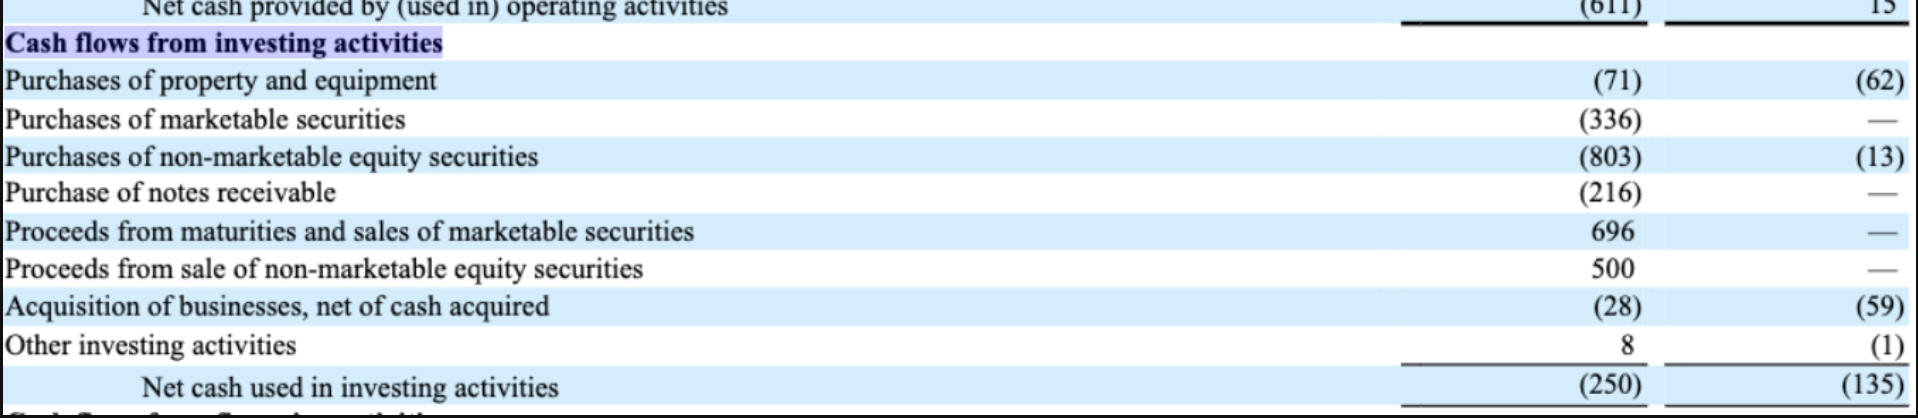

Give a try and see if it works better in your documents.